--- Libraries installed ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading data from: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/preprocessed_batches ---
Found 31 batch files.

--- Calculating data length per patient for robust splitting... ---


Counting Patient Rows:   0%|          | 0/31 [00:00<?, ?it/s]

Splitting into 2166 training patients and 542 validation patients using stratification.

--- Starting Incremental Training for Quantile Models ---


Training Quantile Models:   0%|          | 0/31 [00:00<?, ?it/s]

--- Incremental training complete. ---
Upper model saved to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/quantile_regressor_upper_95.joblib
Lower model saved to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/quantile_regressor_lower_05.joblib

--- Predicting on Validation Set... ---


Predicting on Batches:   0%|          | 0/31 [00:00<?, ?it/s]


--- Final Evaluation ---
Successfully processed 5398570 validation samples.
Mean Absolute Error (Upper 95th): 7.1974
Mean Absolute Error (Lower 5th): 7.0153

--- Risk Forecaster Alarm Performance ---
              precision    recall  f1-score   support

    No Alarm       0.93      0.00      0.00   3150417
       Alarm       0.42      1.00      0.59   2248153

    accuracy                           0.42   5398570
   macro avg       0.68      0.50      0.30   5398570
weighted avg       0.72      0.42      0.25   5398570


--- Confusion Matrix (Alarm vs. No Alarm) ---


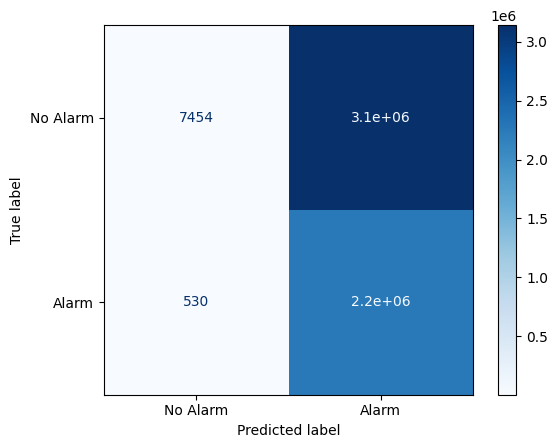


--- Visualizing Predicted Risk Boundaries (Sample) ---


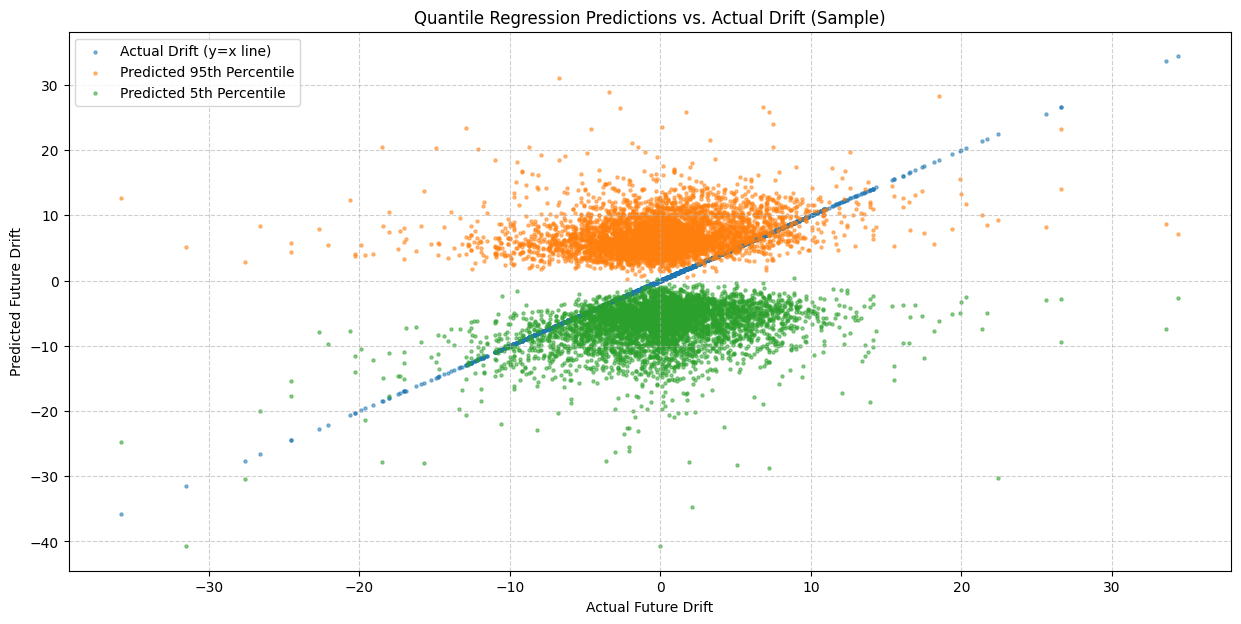

In [ ]:
# --- Path 2: The Risk Forecaster (LightGBM Quantile Regression) - Corrected ---

# Step 1: Install necessary libraries
!pip install lightgbm pandas numpy scikit-learn matplotlib seaborn google-colab imbalanced-learn --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
import joblib
import warnings
from collections import Counter

# Suppress warnings for cleaner output
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

# --- 1. Setup ---
drive.mount('/content/drive')
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
UPPER_MODEL_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'quantile_regressor_upper_95.joblib')
LOWER_MODEL_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'quantile_regressor_lower_05.joblib')

print(f"--- Loading data from: {BATCH_DIR_PATH} ---")
batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))
if not batch_files: raise FileNotFoundError("No batch files found.")
print(f"Found {len(batch_files)} batch files.")

# --- 2. Stratified Split Setup ---
print("\n--- Calculating data length per patient for robust splitting... ---")
patient_row_counts = Counter()
for file_path in tqdm(batch_files, desc="Counting Patient Rows"):
    df_temp = pd.read_parquet(file_path)
    patient_row_counts.update(df_temp.index.get_level_values('patient_id').value_counts().to_dict())

patient_counts_df = pd.DataFrame.from_dict(patient_row_counts, orient='index', columns=['row_count'])
available_patient_ids = patient_counts_df.index.values
patient_counts_df['duration_bin'] = pd.qcut(patient_counts_df['row_count'], q=5, labels=False, duplicates='drop')

train_ids, val_ids = train_test_split(
    available_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_counts_df.loc[available_patient_ids, 'duration_bin']
)
train_ids_set = set(train_ids)
val_ids_set = set(val_ids)
print(f"Splitting into {len(train_ids_set)} training patients and {len(val_ids_set)} validation patients using stratification.")

# --- 3. Incremental Training for TWO Quantile Models ---
print("\n--- Starting Incremental Training for Quantile Models ---")
booster_upper = None # For 95th percentile
booster_lower = None # For 5th percentile

# Define model parameters
params_upper = {'objective': 'quantile', 'alpha': 0.95, 'learning_rate': 0.05, 'num_leaves': 41, 'seed': 42, 'n_jobs': -1, 'verbose': -1}
params_lower = {'objective': 'quantile', 'alpha': 0.05, 'learning_rate': 0.05, 'num_leaves': 41, 'seed': 42, 'n_jobs': -1, 'verbose': -1}

for i, file_path in enumerate(tqdm(batch_files, desc="Training Quantile Models")):
    df_chunk = pd.read_parquet(file_path).reset_index()
    train_chunk = df_chunk[df_chunk['patient_id'].isin(train_ids_set)].copy()
    if train_chunk.empty: continue

    # Feature Engineering - Target is now continuous
    train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
    train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    X_train_chunk = train_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id'])
    y_train_chunk = train_chunk['BIS_drift_30s'] # Continuous target
    X_train_chunk.fillna(0, inplace=True)

    if X_train_chunk.empty: continue

    # THE DEFINITIVE FIX: Set free_raw_data=False because we reuse this dataset.
    train_dataset = lgb.Dataset(X_train_chunk, label=y_train_chunk, free_raw_data=False)

    # Train the upper model
    booster_upper = lgb.train(params_upper, train_dataset, num_boost_round=10, init_model=booster_upper)
    # Train the lower model
    booster_lower = lgb.train(params_lower, train_dataset, num_boost_round=10, init_model=booster_lower)

print("--- Incremental training complete. ---")
joblib.dump(booster_upper, UPPER_MODEL_PATH)
joblib.dump(booster_lower, LOWER_MODEL_PATH)
print(f"Upper model saved to {UPPER_MODEL_PATH}")
print(f"Lower model saved to {LOWER_MODEL_PATH}")

# --- 4. Prediction on Validation Set ---
print("\n--- Predicting on Validation Set... ---")
all_preds_upper = []
all_preds_lower = []
all_y_true_drift = []

for file_path in tqdm(batch_files, desc="Predicting on Batches"):
    df_chunk = pd.read_parquet(file_path).reset_index()
    val_chunk = df_chunk[df_chunk['patient_id'].isin(val_ids_set)].copy()
    if val_chunk.empty: continue

    val_chunk['BIS_future_30s'] = val_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    val_chunk['BIS_drift_30s'] = val_chunk['BIS_future_30s'] - val_chunk['BIS/BIS']
    val_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    X_val_chunk = val_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id'])
    y_val_chunk = val_chunk['BIS_drift_30s']
    X_val_chunk.fillna(0, inplace=True)

    if X_val_chunk.empty: continue

    all_preds_upper.append(booster_upper.predict(X_val_chunk))
    all_preds_lower.append(booster_lower.predict(X_val_chunk))
    all_y_true_drift.append(y_val_chunk)

# --- 5. Final Evaluation ---
print("\n--- Final Evaluation ---")
if not all_y_true_drift:
    print("CRITICAL ERROR: No validation data found.")
else:
    y_true_drift = pd.concat(all_y_true_drift)
    y_pred_upper = np.concatenate(all_preds_upper)
    y_pred_lower = np.concatenate(all_preds_lower)

    print(f"Successfully processed {len(y_true_drift)} validation samples.")
    print(f"Mean Absolute Error (Upper 95th): {mean_absolute_error(y_true_drift, y_pred_upper):.4f}")
    print(f"Mean Absolute Error (Lower 5th): {mean_absolute_error(y_true_drift, y_pred_lower):.4f}")

    # --- Convert to Alarm Classification Problem for Evaluation ---
    DRIFT_ALARM_THRESHOLD = 3.0

    # True Alarms: Did the actual drift exceed the threshold?
    true_alarms = (y_true_drift > DRIFT_ALARM_THRESHOLD) | (y_true_drift < -DRIFT_ALARM_THRESHOLD)

    # Predicted Alarms: Did the predicted risk boundaries exceed the threshold?
    predicted_alarms = (y_pred_upper > DRIFT_ALARM_THRESHOLD) | (y_pred_lower < -DRIFT_ALARM_THRESHOLD)

    print("\n--- Risk Forecaster Alarm Performance ---")
    print(classification_report(true_alarms, predicted_alarms, target_names=['No Alarm', 'Alarm']))

    print("\n--- Confusion Matrix (Alarm vs. No Alarm) ---")
    cm = confusion_matrix(true_alarms, predicted_alarms)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Alarm', 'Alarm'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # --- Visual Check: Plot predictions against true values for a sample ---
    print("\n--- Visualizing Predicted Risk Boundaries (Sample) ---")
    sample_df = pd.DataFrame({
        'True Drift': y_true_drift,
        'Predicted Upper (95%)': y_pred_upper,
        'Predicted Lower (5%)': y_pred_lower
    }).sample(n=5000, random_state=42).sort_values(by='True Drift')

    plt.figure(figsize=(15, 7))
    plt.scatter(sample_df['True Drift'], sample_df['True Drift'], s=5, alpha=0.5, label='Actual Drift (y=x line)')
    plt.scatter(sample_df['True Drift'], sample_df['Predicted Upper (95%)'], s=5, alpha=0.5, label='Predicted 95th Percentile')
    plt.scatter(sample_df['True Drift'], sample_df['Predicted Lower (5%)'], s=5, alpha=0.5, label='Predicted 5th Percentile')
    plt.xlabel("Actual Future Drift")
    plt.ylabel("Predicted Future Drift")
    plt.title("Quantile Regression Predictions vs. Actual Drift (Sample)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()